### import the dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchdiffeq import odeint

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

DATA_PATH = os.path.join("..", "Dataset", "raw_RRI_segments.csv")
OUT_MODEL = os.path.join("..", "Two_Class_Models/saved_models", "NODE_PSR_two_class_best.pth")

### Load PSR dataset and preprocess

In [2]:
# Load CSV
df = pd.read_csv(DATA_PATH)
print("CSV loaded. Shape:", df.shape)

# Merge SR (0) + Pre-AF (1) → 0 (non-AF), keep AF (2) → 1 (AF)
mask_binary = df["label"].isin([0, 1, 2])
df = df[mask_binary].copy()

df["label"] = df["label"].map({
    0: 0,  # SR -> non-AF
    1: 0,  # Pre-AF -> non-AF
    2: 1   # AF -> AF
})

print("Merged SR+Pre-AF as non-AF, AF as positive class.")
print("Final shape:", df.shape)
print("Class distribution:\n", df["label"].value_counts())


CSV loaded. Shape: (14357, 55)
Merged SR+Pre-AF as non-AF, AF as positive class.
Final shape: (14357, 55)
Class distribution:
 label
0    9557
1    4800
Name: count, dtype: int64


### PSR

In [3]:
def phase_space_reconstruct(x, m=3, tau=1):
    """
    x: 1D array of RRI
    m: embedding dimension
    tau: time delay
    Returns flattened PSR embedding: x(t), x(t+tau), ..., x(t+(m-1)*tau)
    """
    x = np.asarray(x)
    N = len(x)
    if N < (m-1)*tau + 1:
        # pad with zeros if too short
        x = np.pad(x, (0, (m-1)*tau + 1 - N), 'constant')
        N = len(x)
    psr_vectors = [x[i:N-(m-1)*tau + i] for i in range(m)]
    psr_flat = np.column_stack(psr_vectors).flatten()
    return psr_flat

# Pick RRI columns
rri_cols = [f"r_{i}" for i in range(50)]

# Compute PSR for all rows with m=3, tau=2
psr_features = df[rri_cols].apply(lambda row: phase_space_reconstruct(row.values, m=3, tau=2), axis=1)
psr_features = np.stack(psr_features.values)  # shape: (num_samples, m*(N-(m-1)*tau))

# Add PSR columns to DataFrame
num_psr_cols = psr_features.shape[1]
psr_col_names = [f"psr_{i}" for i in range(num_psr_cols)]
df_psr = pd.DataFrame(psr_features, columns=psr_col_names, index=df.index)
df = pd.concat([df, df_psr], axis=1)

print("PSR features added (m=3, tau=2). DataFrame shape:", df.shape)




PSR features added (m=3, tau=2). DataFrame shape: (14357, 193)


### Extract features and labels

In [4]:
feature_cols = psr_col_names
meta_cols = ["patient_id", "record_id", "label", "label_str", "orig_len"]

# Feature matrix X and labels y
X = df[feature_cols].values.astype(np.float32)
y = df["label"].values.astype(int)

# Drop rows with NaN or inf
mask_good = np.isfinite(X).all(axis=1)
X = X[mask_good]
y = y[mask_good]

print("Loaded samples:", X.shape, "class counts:", np.bincount(y))


Loaded samples: (14357, 138) class counts: [9557 4800]


### Train / val / test split, scaling and SMOTE (apply SMOTE only to training set)

In [5]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=RANDOM_SEED
)

print("Splits -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# Standardize using training stats
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# SMOTE on training only
smote = SMOTE(random_state=RANDOM_SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE train distribution:", np.bincount(y_train_res))

Splits -> train: (9188, 138) val: (2297, 138) test: (2872, 138)
After SMOTE train distribution: [6116 6116]


### Compute class weights

In [6]:
# compute class weights from resampled training set (used as alpha for focal loss)
cw = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_res), y=y_train_res)
class_weights_tensor = torch.tensor(cw, dtype=torch.float32)
print("Class weights:", cw)

Class weights: [1. 1.]


### Compute focal loss

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean()

### Define model class

In [8]:
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 64),
            nn.Tanh(),
            nn.Linear(64, dim)
        )

    def forward(self, t, x):
        return self.net(x)

class NODEModel(nn.Module):
    def __init__(self, dim, num_classes):
        super(NODEModel, self).__init__()
        self.odefunc = ODEFunc(dim)
        self.classifier = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: (batch, features) — treat as initial state
        t = torch.tensor([0.0, 1.0], dtype=x.dtype, device=x.device)
        out = odeint(self.odefunc, x, t)[-1]
        return self.classifier(out)

### Train model

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
import itertools
from sklearn.metrics import f1_score

def train_with_hyperparameter_tuning(model_class, input_dim, num_classes,
                                     train_dataset, val_dataset,
                                     class_weights_tensor,
                                     param_grid,
                                     save_path=OUT_MODEL,
                                     epochs=8,
                                     patience=2,
                                     device=device):
    class_weights_tensor = class_weights_tensor.to(device)

    best_f1 = 0.0
    best_params = None
    best_state = None

    combos = list(itertools.product(*param_grid.values()))
    print(f"Total combinations: {len(combos)}")

    for combo in combos:
        params = dict(zip(param_grid.keys(), combo))
        print("\nTrying params:", params)

        batch_size = params["batch_size"]
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = model_class(dim=input_dim, num_classes=num_classes).to(device)
        if params["optimizer"] == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
        elif params["optimizer"] == "sgd":
            optimizer = torch.optim.SGD(model.parameters(), lr=params["lr"], momentum=0.9)
        else:
            raise ValueError("Unsupported optimizer")

        criterion = FocalLoss(alpha=class_weights_tensor, gamma=params.get("gamma", 2.0))
        epochs_no_improve = 0
        local_best = 0.0

        for epoch in range(1, epochs + 1):
            model.train()
            running_loss = 0.0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                out = model(xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * xb.size(0)
            train_loss = running_loss / len(train_loader.dataset)

            model.eval()
            preds, trues = [], []
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    out = model(xb)
                    _, p = torch.max(out, dim=1)
                    preds.extend(p.cpu().numpy()); trues.extend(yb.cpu().numpy())

            val_f1 = f1_score(trues, preds, average="weighted")
            print(f"  epoch {epoch} train_loss: {train_loss:.4f} val_f1: {val_f1:.4f}")

            if val_f1 > local_best:
                local_best = val_f1
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print("  early stopping")
                    break

        # update global best
        if local_best > best_f1:
            best_f1 = local_best
            best_params = params
            best_state = model.state_dict().copy()
            torch.save(best_state, save_path)
            print("  -> New global best. Saved model.")

    print(f"\nGlobal best val F1: {best_f1:.4f} params: {best_params}")
    return best_params, best_f1, best_state

# Build datasets (reuse existing X_train_res, y_train_res, X_val, y_val)
train_dataset = TensorDataset(torch.from_numpy(X_train_res.astype(np.float32)), torch.from_numpy(y_train_res.astype(np.int64)))
val_dataset = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val.astype(np.int64)))
test_dataset = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.int64)))

input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)

param_grid = {
    "lr": [1e-3, 5e-4],
    "batch_size": [16, 32],
    "optimizer": ["adam", "sgd"]
}

best_params, best_f1, best_state = train_with_hyperparameter_tuning(
    model_class=NODEModel,
    input_dim=input_dim,
    num_classes=num_classes,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    class_weights_tensor=class_weights_tensor,
    param_grid=param_grid,
    save_path=OUT_MODEL,
    epochs=8,
    patience=2,
    device=device
)

print("Best params:", best_params, "Best val F1:", best_f1)


Total combinations: 8

Trying params: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'adam'}
  epoch 1 train_loss: 0.0916 val_f1: 0.8624
  epoch 2 train_loss: 0.0841 val_f1: 0.8751
  epoch 3 train_loss: 0.0790 val_f1: 0.8601
  epoch 4 train_loss: 0.0743 val_f1: 0.8781
  epoch 5 train_loss: 0.0687 val_f1: 0.8632
  epoch 6 train_loss: 0.0633 val_f1: 0.8902
  epoch 7 train_loss: 0.0590 val_f1: 0.8943
  epoch 8 train_loss: 0.0547 val_f1: 0.8969
  -> New global best. Saved model.

Trying params: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'sgd'}
  epoch 1 train_loss: 0.0961 val_f1: 0.8619
  epoch 2 train_loss: 0.0901 val_f1: 0.8595
  epoch 3 train_loss: 0.0884 val_f1: 0.8641
  epoch 4 train_loss: 0.0873 val_f1: 0.8643
  epoch 5 train_loss: 0.0864 val_f1: 0.8641
  epoch 6 train_loss: 0.0856 val_f1: 0.8669
  epoch 7 train_loss: 0.0845 val_f1: 0.8633
  epoch 8 train_loss: 0.0838 val_f1: 0.8724

Trying params: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'adam'}
  epoch 1 train_loss: 0.0916 val_

### Final evaluation on test set

In [11]:
input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NODEModel(dim=input_dim, num_classes=num_classes).to(device)
state_dict = torch.load(OUT_MODEL, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()
print("✅ Loaded trained NODE model from", OUT_MODEL)

✅ Loaded trained NODE model from ../Two_Class_Models/saved_models/NODE_PSR_two_class_best.pth


In [12]:
test_dataset = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.int64)))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Final evaluation
model.eval()
test_preds, test_trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        _, p = torch.max(out, dim=1)
        test_preds.extend(p.cpu().numpy())
        test_trues.extend(yb.numpy())

print("Test class counts:", np.bincount(test_trues))
print("Accuracy:", accuracy_score(test_trues, test_preds))
print("F1 (weighted):", f1_score(test_trues, test_preds, average="weighted"))
print("\nClassification report:\n", classification_report(test_trues, test_preds, target_names=["SR","AF"]))
print("\nConfusion matrix:\n", confusion_matrix(test_trues, test_preds))

Test class counts: [1912  960]
Accuracy: 0.8917130919220055
F1 (weighted): 0.8927106832663313

Classification report:
               precision    recall  f1-score   support

          SR       0.94      0.90      0.92      1912
          AF       0.81      0.88      0.84       960

    accuracy                           0.89      2872
   macro avg       0.87      0.89      0.88      2872
weighted avg       0.90      0.89      0.89      2872


Confusion matrix:
 [[1717  195]
 [ 116  844]]


In [13]:
prob_danger = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1)[:, 1]   # class 1 = AF (danger)
        prob_danger.extend(probs.cpu().numpy())

prob_danger = np.array(prob_danger)
test_trues = np.array(test_trues)  

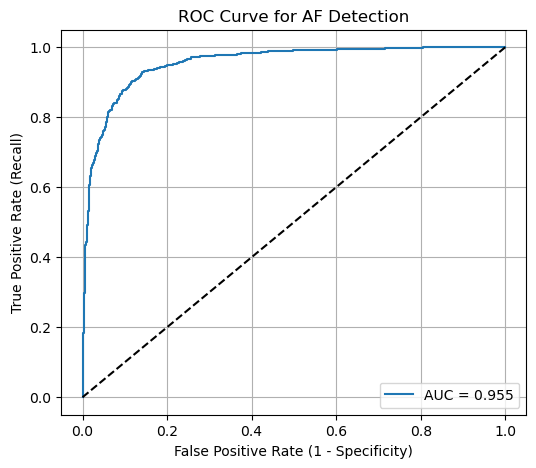

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thr = roc_curve(test_trues, prob_danger)
auc = roc_auc_score(test_trues, prob_danger)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve for AF Detection")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


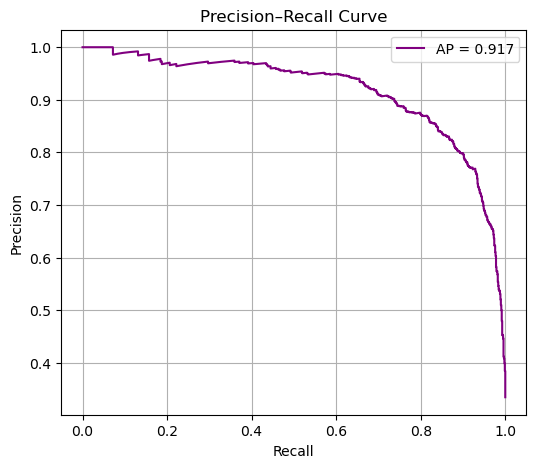

In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, thr = precision_recall_curve(test_trues, prob_danger)
ap = average_precision_score(test_trues, prob_danger)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, color='purple', label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


### Find threshold


========== Threshold Comparison ==========

✅ Best threshold = 0.6000000000000001
F1=0.841, Acc=0.897, Prec=0.867, Rec=0.817, BalAcc=0.877


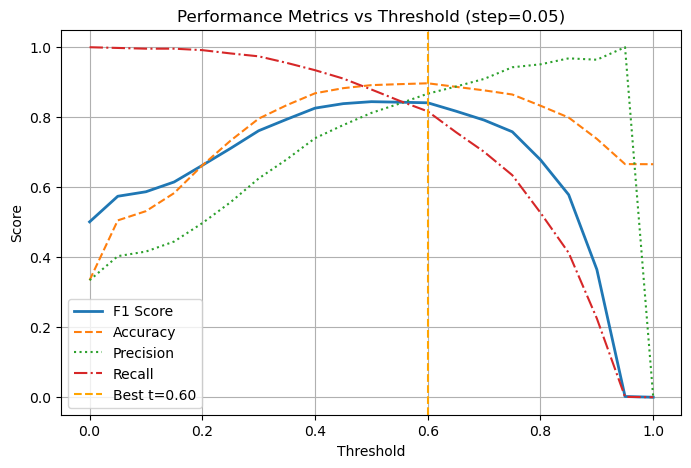

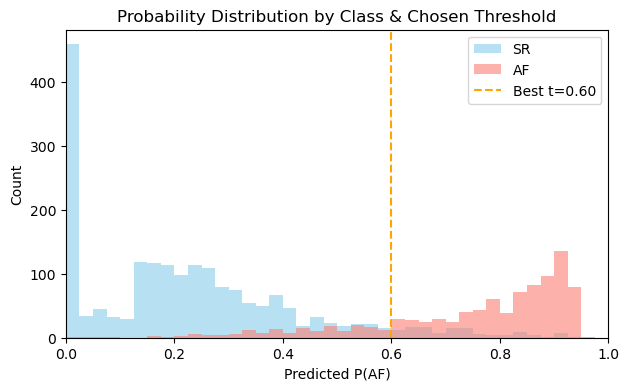

In [16]:
# --- Additional threshold comparison (after argmax eval) ---
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score,
    recall_score, balanced_accuracy_score, confusion_matrix
)

print("\n========== Threshold Comparison ==========")

# --- Recompute continuous probabilities ---
prob_danger = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1)[:, 1]   # class 1 = AF (danger)
        prob_danger.extend(probs.cpu().numpy())

prob_danger = np.array(prob_danger)
test_trues = np.array(test_trues)  # reuse from before

# --- Sweep thresholds from 0.0 to 1.0 in 0.05 steps ---
candidates = np.arange(0.0, 1.01, 0.05)
results = []

f1s, accs, precs, recs = [], [], [], []

for t in candidates:
    preds = (prob_danger >= t).astype(int)
    f1  = f1_score(test_trues, preds, zero_division=0)
    acc = accuracy_score(test_trues, preds)
    prec = precision_score(test_trues, preds, zero_division=0)
    rec  = recall_score(test_trues, preds)
    balacc = balanced_accuracy_score(test_trues, preds)
    results.append((t, f1, acc, prec, rec, balacc))
    
    f1s.append(f1)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)

# --- Find best threshold by combined (F1 + Acc) ---
best = max(results, key=lambda x: (x[1] + x[2]) / 2)
best_t, best_f1, best_acc, best_prec, best_rec, best_balacc = best

print("\n✅ Best threshold =", best_t)
print(f"F1={best_f1:.3f}, Acc={best_acc:.3f}, Prec={best_prec:.3f}, Rec={best_rec:.3f}, BalAcc={best_balacc:.3f}")

# --- 1️⃣ Plot metric trends across thresholds ---
plt.figure(figsize=(8,5))
plt.plot(candidates, f1s, label="F1 Score", linewidth=2)
plt.plot(candidates, accs, label="Accuracy", linestyle="--")
plt.plot(candidates, precs, label="Precision", linestyle=":")
plt.plot(candidates, recs, label="Recall", linestyle="-.")
plt.axvline(best_t, color="orange", linestyle="--", label=f"Best t={best_t:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Performance Metrics vs Threshold (step=0.05)")
plt.legend()
plt.grid(True)
plt.show()

# --- 2️⃣ Plot probability distribution by class ---
plt.figure(figsize=(7,4))
plt.hist(prob_danger[test_trues==0], bins=40, range=(0,1), alpha=0.6, label="SR", color="skyblue")
plt.hist(prob_danger[test_trues==1], bins=40, range=(0,1), alpha=0.6, label="AF", color="salmon")
plt.axvline(best_t, color="orange", linestyle="--", label=f"Best t={best_t:.2f}")
plt.xlim(0, 1)
plt.xlabel("Predicted P(AF)")
plt.ylabel("Count")
plt.title("Probability Distribution by Class & Chosen Threshold")
plt.legend()
plt.show()
